In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

Train Data with all features

In [10]:
X_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/X_train_processed.pkl")
y_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/y_train_over.pkl")

In [11]:
X_train.drop(columns=["date"], inplace=True)

In [12]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini'
)

In [13]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve All variables')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [14]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train.iloc[index])[:,1]
    y_predict = clf.predict(X_train.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

In [15]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

In [16]:
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

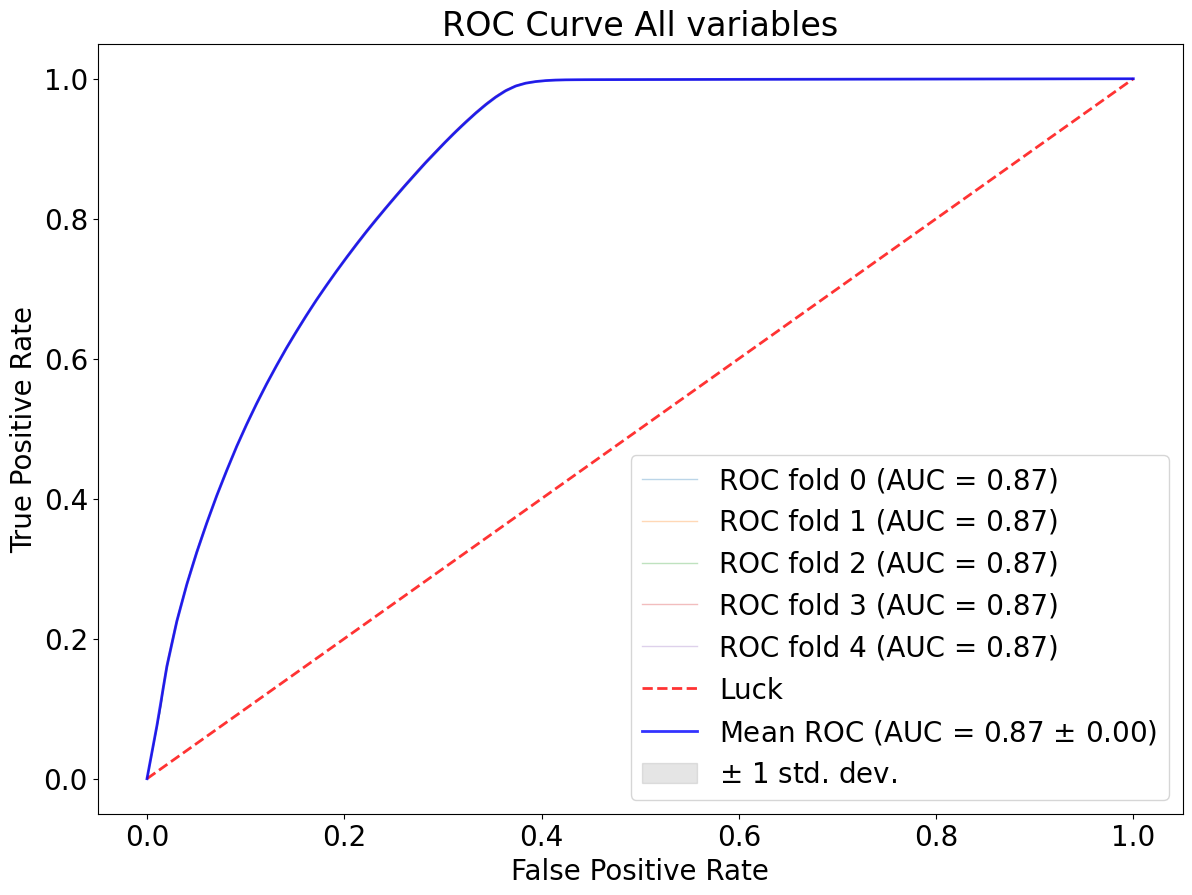

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.917285,0.871601,0.838580,0.801086,0.784152,0.753270,0.934353,0.895482
1,0.917276,0.871868,0.838446,0.801954,0.784056,0.754268,0.934184,0.895724
2,0.917363,0.871182,0.838620,0.800968,0.784327,0.753092,0.934098,0.895552
3,0.917321,0.871744,0.838479,0.801847,0.783867,0.754006,0.934671,0.896022
4,0.917364,0.871368,0.838601,0.800968,0.784530,0.753664,0.933620,0.894211


In [17]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

Test Data with all features

In [18]:
X_test = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/X_test_processed.pkl")
y_test = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/y_test.pkl")

In [19]:
X_test.drop(columns=["date"], inplace=True)

In [20]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC + compute AUC scores.
    tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
    tprs_interp[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve Test All variables')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

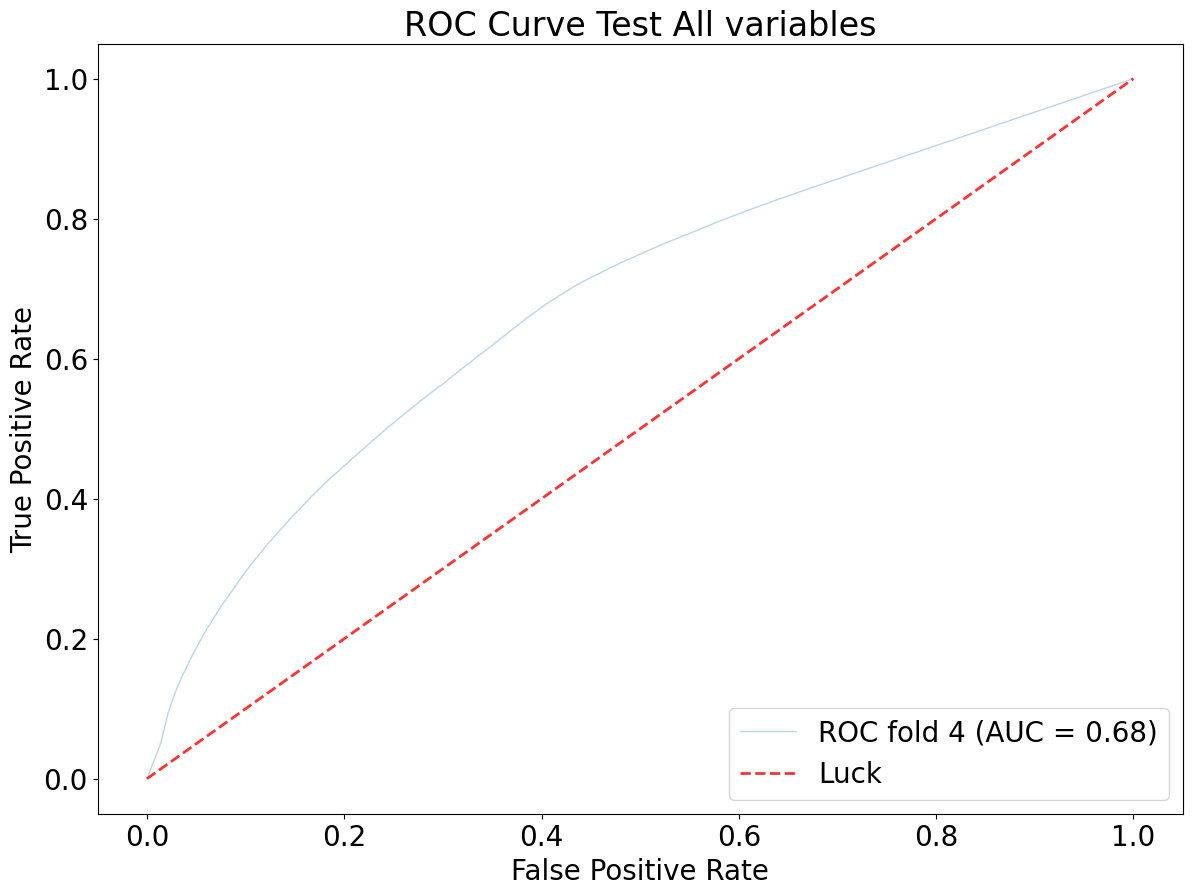

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'ROC Curve Test All variables'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [21]:
fprs, tprs, scores = [], [], []

y_predict_prob = clf.predict_proba(X_test)[:,1]
y_predict = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob)
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
scores.append((auc_score, accuracy, precision, recall))

plot_roc_curve(fpr, tpr)

In [22]:
pd.DataFrame(scores, columns=['AUC'
                              ,'Accuracy'
                              ,'Precision'
                              ,'Recall'])

,AUC,Accuracy,Precision,Recall
0,0.678619,0.687226,0.228619,0.555992


Train Data with feature selection

In [23]:
clf_fs = RandomForestClassifier(
    n_estimators=50,
    criterion='gini'
)

In [24]:
# feature selection
X_train_2 = X_train[['relative_humidity',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA']]

In [25]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve Selected Variables')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

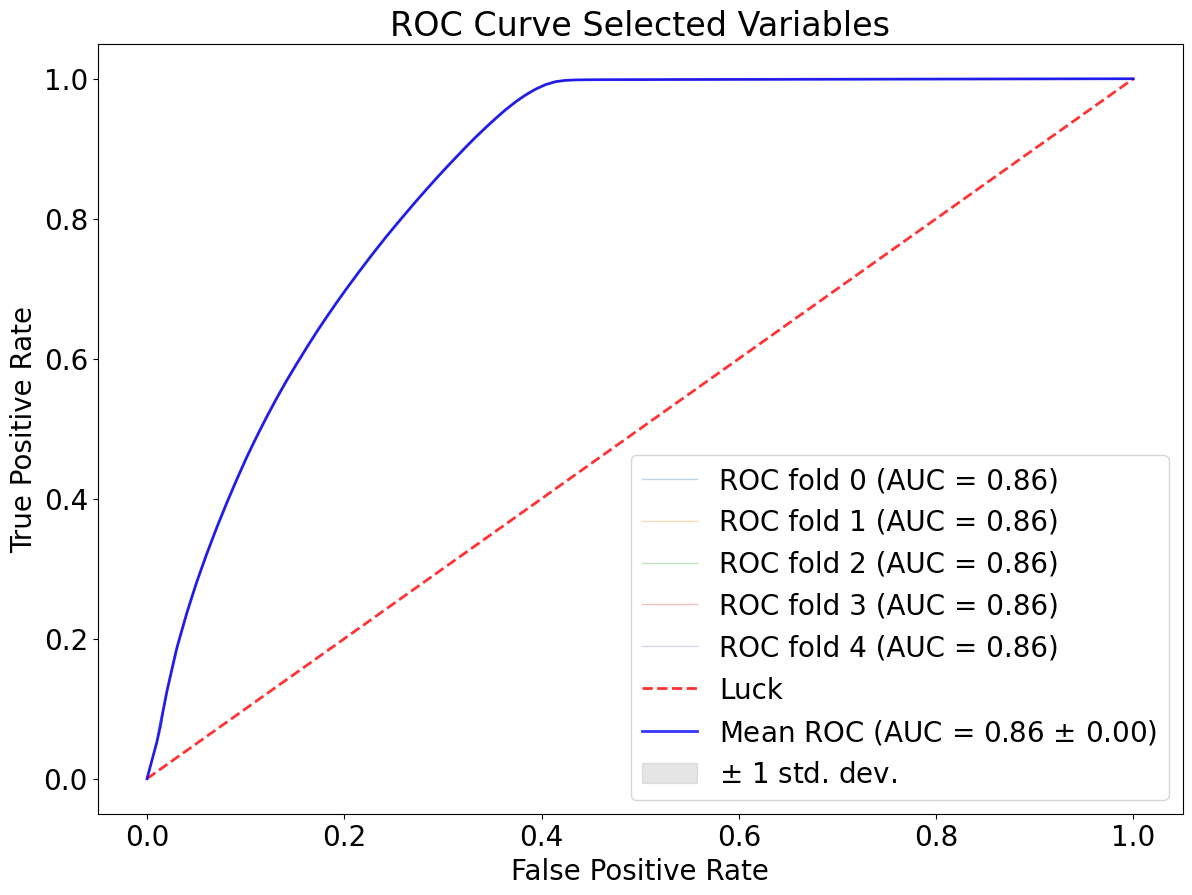

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.907108,0.856060,0.827398,0.786950,0.773359,0.739440,0.926241,0.886162
1,0.907112,0.856143,0.827296,0.787285,0.773349,0.739829,0.925974,0.886220
2,0.907134,0.855624,0.827403,0.786627,0.773310,0.738872,0.926362,0.886589
3,0.907182,0.855746,0.827317,0.786946,0.773330,0.739647,0.926074,0.885630
4,0.907126,0.856134,0.827367,0.786818,0.773591,0.739616,0.925646,0.885315


In [26]:
def compute_roc_auc(index):
    y_predict_prob = clf_fs.predict_proba(X_train_2.iloc[index])[:,1]
    y_predict = clf_fs.predict(X_train_2.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_2, y_train), range(5)):
    clf_fs.fit(X_train_2.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

Test Data with feature selection

In [27]:
# feature selection
X_test_2= X_test[['relative_humidity',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA']]

In [30]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC + compute AUC scores.
    tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
    tprs_interp[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve Test All variables')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

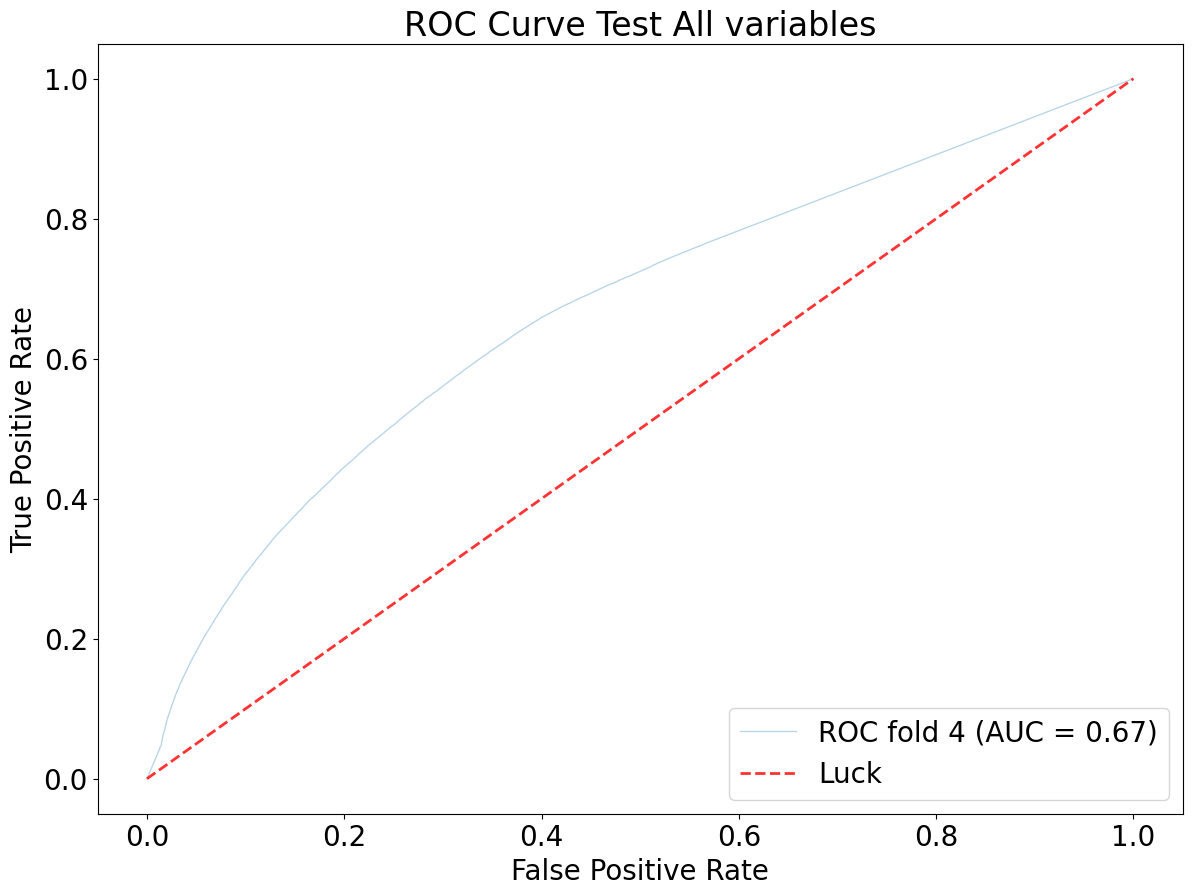

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'ROC Curve Test All variables'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [31]:
fprs, tprs, scores = [], [], []

y_predict_prob = clf_fs.predict_proba(X_test_2)[:,1]
y_predict = clf_fs.predict(X_test_2)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob)
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
scores.append((auc_score, accuracy, precision, recall))

plot_roc_curve(fpr, tpr)

In [32]:
pd.DataFrame(scores, columns=['AUC'
                              ,'Accuracy'
                              ,'Precision'
                              ,'Recall'])

,AUC,Accuracy,Precision,Recall
0,0.667244,0.672633,0.222744,0.573705


In [44]:
confusion_matrix = pd.crosstab(y_test, y_predict, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted   False   True 
Actual                   
False      473632  214738
True        45727   61539


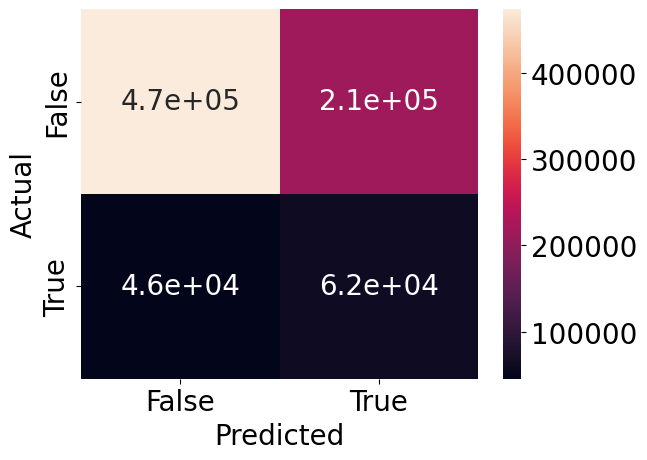

In [45]:
import seaborn as sn
import matplotlib.pyplot as plt


sn.heatmap(confusion_matrix, annot=True)
plt.show()


In [49]:
feature_importance = clf_fs.feature_importances_


In [50]:
feature_names = clf_fs.feature_names_in_


In [52]:
df_feature_importance = pd.DataFrame({'Feature':feature_names, 'Importance': feature_importance})

In [53]:
df_feature_importance

,Feature,Importance
0,relative_humidity,0.946185
1,month_APR,0.000991
2,month_AUG,0.004513
3,month_DEC,0.000522
4,month_FEB,0.000358
5,month_JAN,0.000640
6,month_JUL,0.003315
7,month_JUN,0.000901
8,month_MAR,0.000422
9,month_MAY,0.000449


In [56]:
df_feature_importance.sort_values('Importance', ascending=False)


,Feature,Importance
0,relative_humidity,0.946185
16,departure_region_BRUSSELS-CAPITAL REGION,0.015148
18,departure_region_WALLONIA,0.007683
17,departure_region_FLANDERS,0.005622
10,month_NOV,0.004558
2,month_AUG,0.004513
6,month_JUL,0.003315
11,month_OCT,0.002781
14,destination_region_FLANDERS,0.001971
13,destination_region_BRUSSELS-CAPITAL REGION,0.001968


In [64]:
# feature selection
X_train_3= X_train[['relative_humidity',
      'month_AUG',
       'month_JUL', 'month_NOV',
       'month_OCT', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA']]

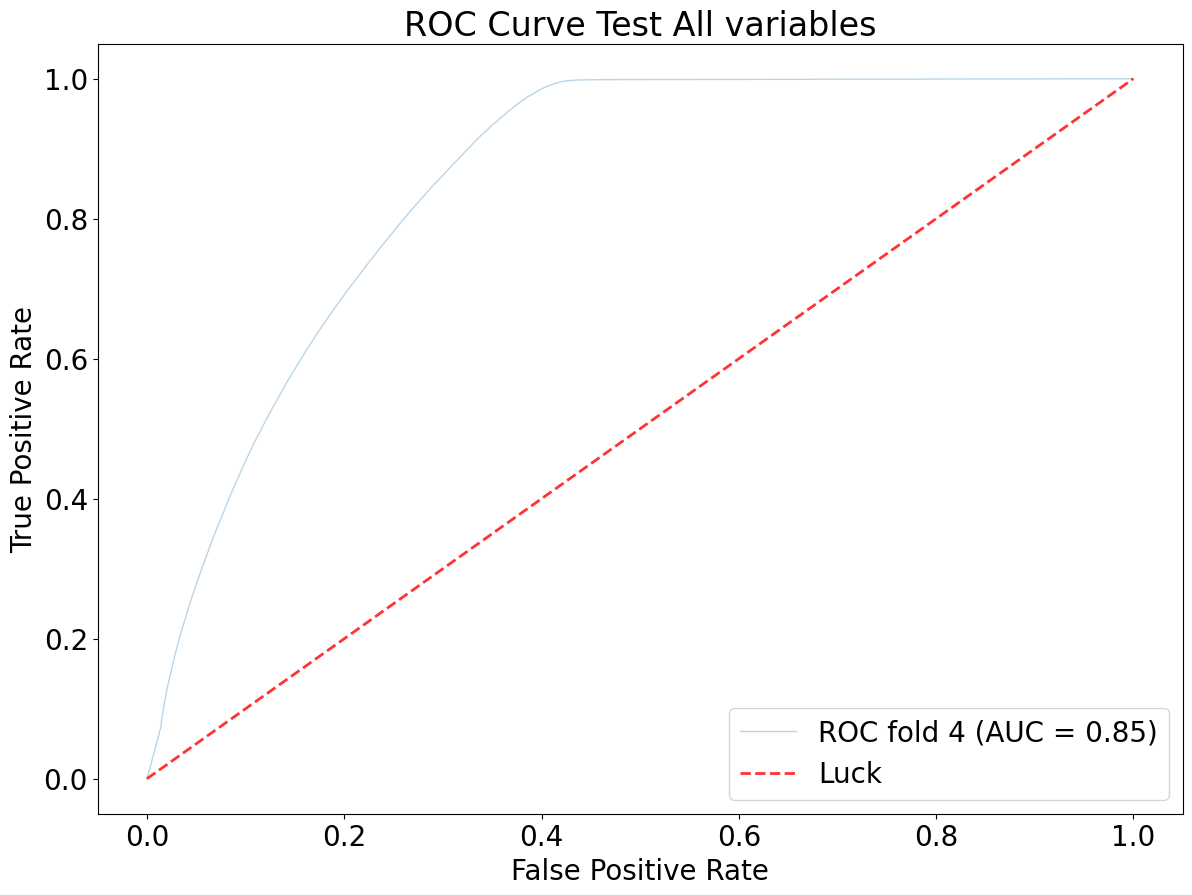

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.905619,0.854544,0.825477,0.785070,0.771805,0.737778,0.924209,0.884516
1,0.905616,0.854693,0.825371,0.785012,0.772025,0.738164,0.923426,0.883363
2,0.905639,0.854323,0.825466,0.784959,0.771698,0.737688,0.924415,0.884400
3,0.905675,0.854358,0.825377,0.785309,0.771644,0.738270,0.924280,0.884020
4,0.905650,0.854421,0.825467,0.784575,0.772000,0.737692,0.923754,0.883196


In [66]:
def compute_roc_auc(index):
    y_predict_prob = clf_fs.predict_proba(X_train_3.iloc[index])[:,1]
    y_predict = clf_fs.predict(X_train_3.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train_3, y_train), range(5)):
    clf_fs.fit(X_train_3.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [67]:
# feature selection
X_test_3= X_test[['relative_humidity',
      'month_AUG',
       'month_JUL', 'month_NOV',
       'month_OCT', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA']]

In [69]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC + compute AUC scores.
    tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
    tprs_interp[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    ax.plot(fpr, tpr, lw=1, alpha=0.3,
                label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve Test All variables')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

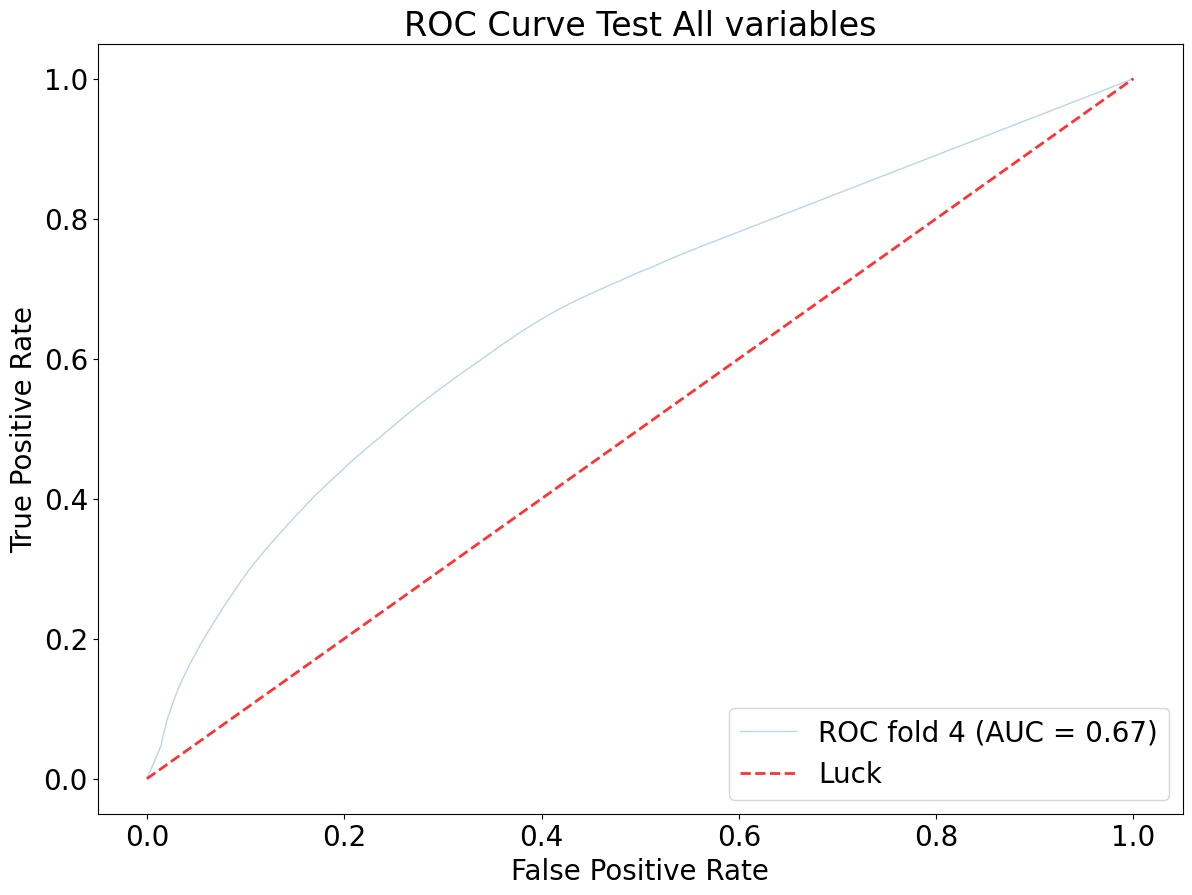

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'ROC Curve Test All variables'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [70]:
fprs, tprs, scores = [], [], []

y_predict_prob = clf_fs.predict_proba(X_test_3)[:,1]
y_predict = clf_fs.predict(X_test_3)
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob)
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)
scores.append((auc_score, accuracy, precision, recall))

plot_roc_curve(fpr, tpr)

In [71]:
pd.DataFrame(scores, columns=['AUC'
                              ,'Accuracy'
                              ,'Precision'
                              ,'Recall'])

,AUC,Accuracy,Precision,Recall
0,0.666059,0.671126,0.22186,0.574068
